Датасет: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small, классификация изображений.

 В датасете несколько разных классификаций, используйте "subCategory" в качестве рабочей. Задача - обучить обычную CNN и Resnet50 на этом наборе с иллюстрацией процесса обучения для обеих моделей и выводом времени обучения (при равном количестве эпох), а затем обучить те же модели (без запоминания весов, т.е. сначала), но вчетверо уменьшить размеры обучающей выборки (удалить 3/4 картинок из каждого класса). Сделать вывод относительно того, как показывают себя обе модели в условиях меньшего количества обучающих данных.

# Библиотеки

In [ ]:
!pip install opendatasets pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 625.0 kB/s eta 0:00:00


In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small")

100%|██████████| 565M/565M [00:25<00:00, 23.2MB/s]


In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import warnings
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Conv2D, MaxPooling2D, Flatten
warnings.filterwarnings(action = 'ignore')


In [ ]:
sns.set(font_scale=0.5)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8442822493392164843
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 712758006824639816
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Датасет

In [ ]:
DATASET_PATH = "./fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


In [ ]:
df = pd.read_csv(DATASET_PATH+"/styles.csv", error_bad_lines = False)
df['image'] = df.apply(lambda row:str(row['id'])+".jpg",axis = 1).reset_index(drop = True)
df.head()

Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 fields, saw 11
Skipping line 37770: expected 10 fields, saw 11
Skipping line 38105: expected 10 fields, saw 11
Skipping line 38275: expected 10 fields, saw 

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


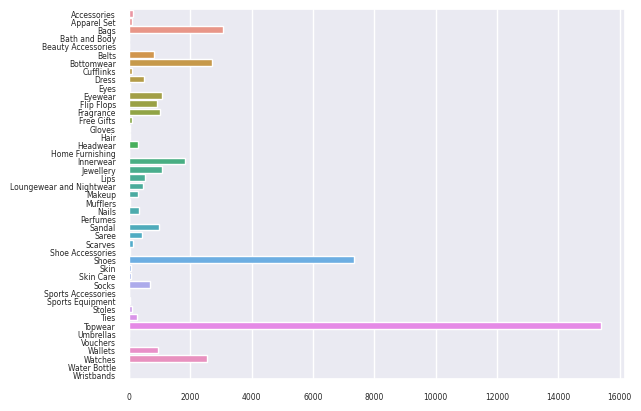

In [ ]:
unique, counts = np.unique(df.subCategory, return_counts=True)
sns.barplot(x=counts, y=unique)
None

In [ ]:
df_uniques = pd.DataFrame({'unique': unique, 'counts': counts}).sort_values('counts', ascending=False)
df_uniques

,unique,counts
38,Topwear,15402
30,Shoes,7343
2,Bags,3055
6,Bottomwear,2694
42,Watches,2542
18,Innerwear,1808
19,Jewellery,1079
10,Eyewear,1073
12,Fragrance,1011
26,Sandal,963


Уберем из датасета классы, которые встречаются меньше 200 раз

In [ ]:
df = df[df['subCategory'].isin(df_uniques[df_uniques.counts > 200].unique)]

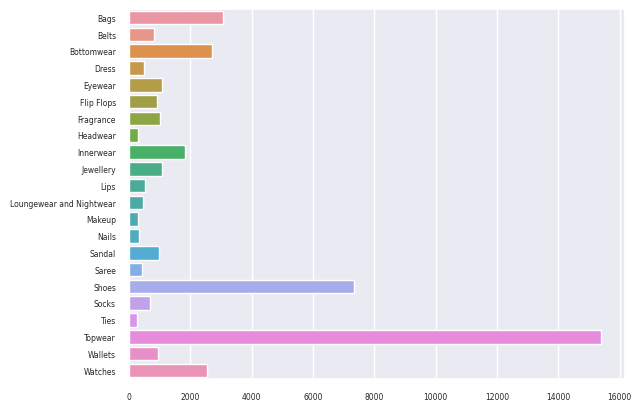

In [ ]:
unique, counts = np.unique(df.subCategory, return_counts=True)
sns.barplot(x=counts, y=unique)
None

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    validation_split=0.2
)

training_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=128,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=128,
    subset="validation"
)

classes = len(training_generator.class_indices)

Found 34728 validated image filenames belonging to 22 classes.
Found 8681 validated image filenames belonging to 22 classes.


# Надстройки

In [ ]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.995:
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
input_size = (96, 96, 3)

In [ ]:
batch_size = 32
epochs = 5

# Обучение на большом количестве данных

In [ ]:
model_ResNet50 = ResNet50(weights = 'imagenet',
                   include_top = False,
                   input_shape = input_size)
model_ResNet50.trainable = False

# Adding Embedding Layer
model_ResNet50 = tf.keras.models.Sequential([
    model_ResNet50,
    GlobalMaxPooling2D(),
    Dense(classes, activation='softmax')
])

model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_ResNet50.summary()

94765736/94765736 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 22)                45078     
                                                                 
Total params: 23,632,790
Trainable params: 45,078
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from math import floor

time_callback = TimeHistory()
callbacks = myCallback()

history = model_ResNet50.fit_generator(
    generator=training_generator,
    steps_per_epoch=batch_size,

    validation_data=validation_generator,
    validation_steps=batch_size/2,

    epochs=epochs,
    verbose=1,

    callbacks=[time_callback, callbacks]
)

Epoch 1/5
32/32 [==============================] - 19s 210ms/step - loss: 1.8685 - accuracy: 0.6616 - val_loss: 0.8938 - val_accuracy: 0.7993
Epoch 2/5
32/32 [==============================] - 6s 197ms/step - loss: 0.6423 - accuracy: 0.8403 - val_loss: 0.6617 - val_accuracy: 0.8516
Epoch 3/5
32/32 [==============================] - 5s 157ms/step - loss: 0.5645 - accuracy: 0.8601 - val_loss: 0.4815 - val_accuracy: 0.8560
Epoch 4/5
32/32 [==============================] - 7s 210ms/step - loss: 0.4730 - accuracy: 0.8799 - val_loss: 0.4769 - val_accuracy: 0.8682
Epoch 5/5
32/32 [==============================] - 6s 177ms/step - loss: 0.3958 - accuracy: 0.8940 - val_loss: 0.4760 - val_accuracy: 0.8794


In [ ]:
print(f'Время обучения: {sum(time_callback.times):.2f} секунды')

Время обучения: 42.51 секунды


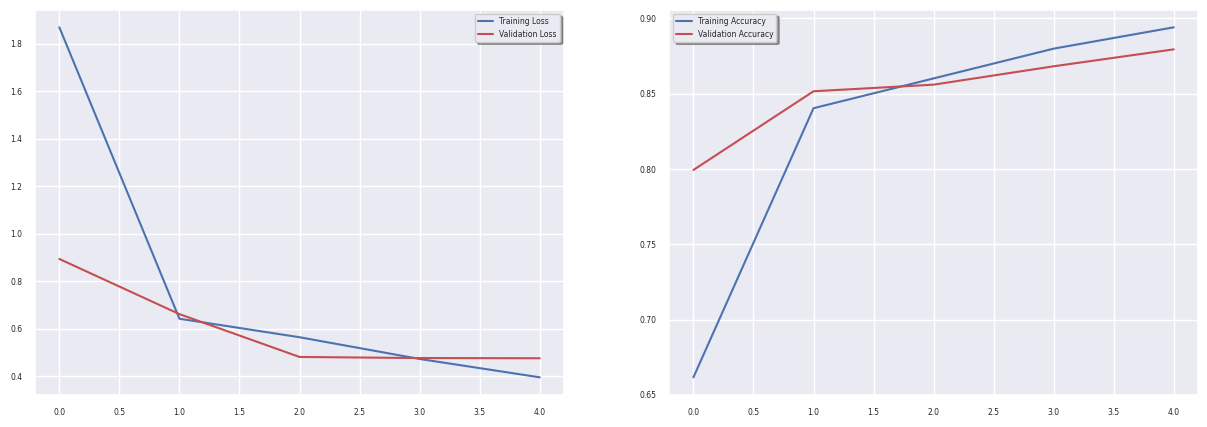

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
model_cnn = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_size),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 25600)            

In [ ]:
time_callback = TimeHistory()
callbacks = myCallback()

history_cnn = model_cnn.fit_generator(
    generator=training_generator,
    steps_per_epoch=batch_size,

    validation_data=validation_generator,
    validation_steps=batch_size/2,

    epochs=epochs,
    verbose=1,

    callbacks=[time_callback, callbacks]
)

Epoch 1/5
32/32 [==============================] - 9s 127ms/step - loss: 19.6895 - accuracy: 0.5347 - val_loss: 0.9441 - val_accuracy: 0.7598
Epoch 2/5
32/32 [==============================] - 4s 120ms/step - loss: 1.0136 - accuracy: 0.7434 - val_loss: 0.8211 - val_accuracy: 0.7778
Epoch 3/5
32/32 [==============================] - 4s 113ms/step - loss: 0.7713 - accuracy: 0.7974 - val_loss: 0.6940 - val_accuracy: 0.8115
Epoch 4/5
32/32 [==============================] - 5s 166ms/step - loss: 0.6838 - accuracy: 0.8171 - val_loss: 0.7486 - val_accuracy: 0.8130
Epoch 5/5
32/32 [==============================] - 4s 110ms/step - loss: 0.5807 - accuracy: 0.8357 - val_loss: 0.5334 - val_accuracy: 0.8604


In [ ]:
print(f'Время обучения: {sum(time_callback.times):.2f} секунды')

Время обучения: 25.52 секунды


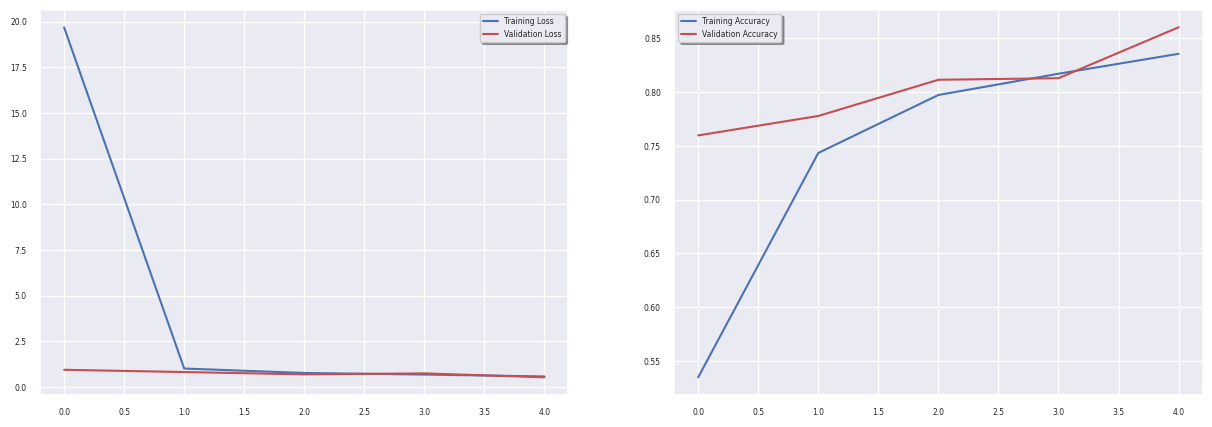

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_cnn.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_cnn.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_cnn.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_cnn.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Уменьшение данных

In [ ]:
training_generator = image_generator.flow_from_dataframe(
    dataframe=df.iloc[:round(df.shape[0] / 4)],
    directory=DATASET_PATH + "images",
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=128,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=df.iloc[:round(df.shape[0] / 4)],
    directory=DATASET_PATH + "images",
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=128,
    subset="validation"
)

classes = len(training_generator.class_indices)

Found 8683 validated image filenames belonging to 22 classes.
Found 2170 validated image filenames belonging to 22 classes.


# Обучение на меньших данных

In [ ]:
model_ResNet50 = ResNet50(weights = 'imagenet',
                   include_top = False,
                   input_shape = input_size)
model_ResNet50.trainable = False

# Adding Embedding Layer
model_ResNet50 = tf.keras.models.Sequential([
    model_ResNet50,
    GlobalMaxPooling2D(),
    Dense(classes, activation='softmax')
])

model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from math import ceil

time_callback = TimeHistory()
callbacks = myCallback()

history = model_ResNet50.fit_generator(
    generator=training_generator,
    steps_per_epoch=batch_size,

    validation_data=validation_generator,
    validation_steps=batch_size / 2,

    epochs=epochs,
    verbose=1,

    callbacks=[time_callback, callbacks]
)

Epoch 1/5
32/32 [==============================] - 9s 170ms/step - loss: 2.2632 - accuracy: 0.6335 - val_loss: 0.8907 - val_accuracy: 0.7793
Epoch 2/5
32/32 [==============================] - 5s 154ms/step - loss: 0.6485 - accuracy: 0.8452 - val_loss: 0.6591 - val_accuracy: 0.8433
Epoch 3/5
32/32 [==============================] - 5s 160ms/step - loss: 0.4776 - accuracy: 0.8773 - val_loss: 0.5584 - val_accuracy: 0.8594
Epoch 4/5
32/32 [==============================] - 5s 171ms/step - loss: 0.3802 - accuracy: 0.8977 - val_loss: 0.5810 - val_accuracy: 0.8516
Epoch 5/5
32/32 [==============================] - 4s 137ms/step - loss: 0.2945 - accuracy: 0.9197 - val_loss: 0.4710 - val_accuracy: 0.8892


In [ ]:
print(f'Время обучения: {sum(time_callback.times):.2f} секунды')

Время обучения: 28.47 секунды


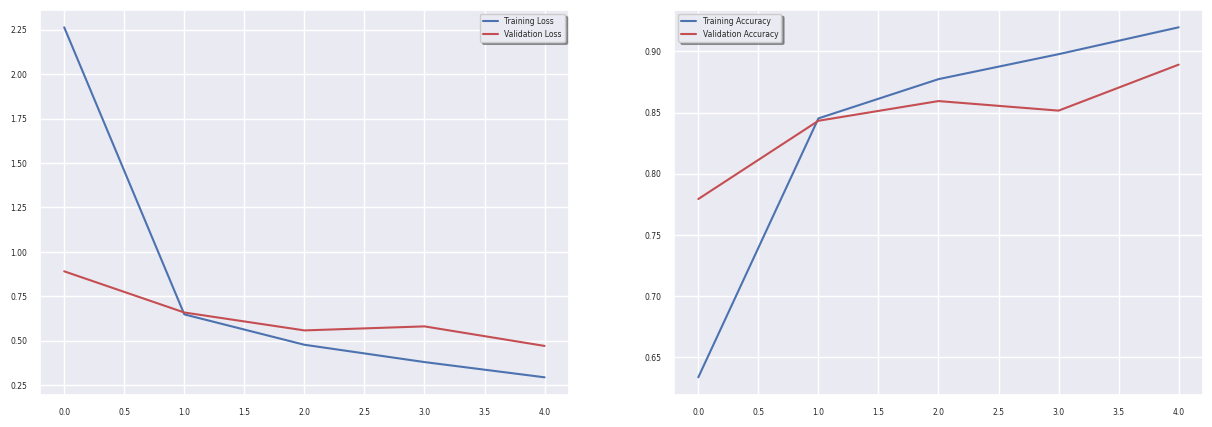

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
model_cnn = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_size),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(classes, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
time_callback = TimeHistory()
callbacks = myCallback()

history_cnn = model_cnn.fit_generator(
    generator=training_generator,
    steps_per_epoch=batch_size,

    validation_data=validation_generator,
    validation_steps=batch_size/2,

    epochs=epochs,
    verbose=1,

    callbacks=[time_callback, callbacks]
)

Epoch 1/5
32/32 [==============================] - 7s 139ms/step - loss: 24.6591 - accuracy: 0.4724 - val_loss: 1.0873 - val_accuracy: 0.7197
Epoch 2/5
32/32 [==============================] - 6s 175ms/step - loss: 1.0954 - accuracy: 0.7183 - val_loss: 0.9845 - val_accuracy: 0.7637
Epoch 3/5
32/32 [==============================] - 4s 117ms/step - loss: 0.6929 - accuracy: 0.8223 - val_loss: 0.6901 - val_accuracy: 0.8203
Epoch 4/5
32/32 [==============================] - 6s 199ms/step - loss: 0.4708 - accuracy: 0.8709 - val_loss: 0.6663 - val_accuracy: 0.8330
Epoch 5/5
32/32 [==============================] - 9s 288ms/step - loss: 0.4442 - accuracy: 0.8852 - val_loss: 0.6479 - val_accuracy: 0.8296


In [ ]:
print(f'Время обучения: {sum(time_callback.times):.2f} секунды')

Время обучения: 31.89 секунды


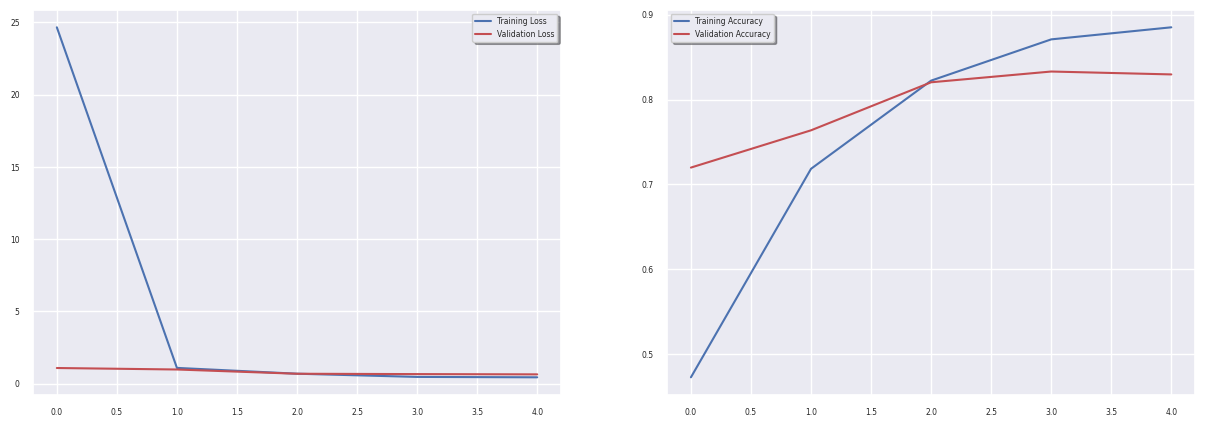

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_cnn.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_cnn.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_cnn.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_cnn.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Выводы

На большом количестве данных модель ResNet50 превосходит обычную CNN на 12%. Однако на данных в 4 раза меньше сети выходят примерно на один уровень, имея разрыв в 4%.

ResNet50: 0.8604 -> 0.8701

CNN: 0.7412 -> 0.8374

Уменьшение данных также сыграло роль в скорости обучения:

ResNet50: 649.68 -> 1147.00 секунд

CNN: 202.86 -> 442.81 секунды

Показалось странным, что время обучения увеличилось, хотя по логике должно было произойти обратное

Однако с GPU результаты изменились:

Accuracy:

ResNet50: 0.8794 -> 0.8892

CNN: 0.8604 -> 0.8296

Time:

ResNet50: 42.51 -> 28.47 секунд

CNN: 25.52 -> 31.89 секунды